In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset = "/content/drive/MyDrive/money.stackexchange.com/"


In [3]:
import pandas as pd
import pickle

df_QA = pd.read_csv(dataset+"Q_A_info.csv")
df_Users = pd.read_csv(dataset+"Users_cleaned.csv")





In [4]:
df_QA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71899 entries, 0 to 71898
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             71899 non-null  int64  
 1   qId                    71899 non-null  int64  
 2   qOwnerUserId           71899 non-null  int64  
 3   qBody_Count            71899 non-null  int64  
 4   qBody_Sentiment        71899 non-null  float64
 5   qTitle_Count           71899 non-null  int64  
 6   qTitle_Sentiment       71899 non-null  float64
 7   aId                    68527 non-null  float64
 8   aScore                 68527 non-null  float64
 9   aOwnerUserId           68527 non-null  float64
 10  aParentId              68527 non-null  float64
 11  aBody_Count            68527 non-null  float64
 12  aBody_Sentiment        68527 non-null  float64
 13  response_time_minutes  68527 non-null  float64
 14  accepted               71899 non-null  object 
dtypes:

In [5]:
df_Users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96890 entries, 0 to 96889
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          96890 non-null  int64  
 1   Reputation          96890 non-null  int64  
 2   AccountId           96890 non-null  int64  
 3   has_website         96890 non-null  bool   
 4   account_age_days    96890 non-null  int64  
 5   AboutMe_Word_Count  96890 non-null  int64  
 6   AboutMe_Sentiment   96890 non-null  float64
dtypes: bool(1), float64(1), int64(5)
memory usage: 4.5 MB


In [6]:
df_QA.fillna({'aId': -1, 'aScore': 0, 'aOwnerUserId': -1}, inplace=True)


In [7]:
weight_for_zero = 0.01
df_QA['edge_weight'] = df_QA['response_time_minutes'].apply(lambda x:1/(x+weight_for_zero))

In [20]:
#max_score = df_QA['aScore'].max()
#df_QA['normalized_score'] = df_QA['aScore'] / max_score

#max_time = df_QA['response_time_minutes'].max()
#df_QA['normalized_time'] = 1/df_QA['response_time_minutes']

#df_QA['normalized_sentiment'] = (df_QA['aBody_Sentiment'] + 1) / 2
#df_QA['edge_weight'] = 0.4 * (1 - df_QA['normalized_time']) + 0.4 * df_QA['normalized_score'] + 0.2 * df_QA['normalized_sentiment']


In [8]:
df_QA

,Unnamed: 0,qId,qOwnerUserId,qBody_Count,qBody_Sentiment,qTitle_Count,qTitle_Sentiment,aId,aScore,aOwnerUserId,aParentId,aBody_Count,aBody_Sentiment,response_time_minutes,accepted,edge_weight
0,0,7,5,33,0.400000,10,0.60,185.0,5.0,95.0,7.0,105.0,0.345000,42338.896767,No,0.000024
1,1,7,5,33,0.400000,10,0.60,282.0,6.0,94.0,7.0,390.0,0.124531,59047.816500,Yes,0.000017
2,2,7,5,33,0.400000,10,0.60,2446.0,4.0,828.0,7.0,18.0,0.187500,435822.625050,No,0.000002
3,3,22,13,33,0.000000,14,0.55,25.0,5.0,3.0,22.0,357.0,0.181485,522.844567,No,0.001913
4,4,23,14,17,0.187500,21,0.00,24.0,8.0,13.0,23.0,345.0,0.126188,300.546883,Yes,0.003327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71894,71894,162079,5656,47,0.000000,18,0.00,162080.0,0.0,2998.0,162079.0,66.0,-0.055556,25.442217,No,0.039289
71895,71895,162081,128660,190,-0.012500,5,0.00,162082.0,5.0,2998.0,162081.0,145.0,-0.030647,230.924000,No,0.004330
71896,71896,162081,128660,190,-0.012500,5,0.00,162084.0,4.0,5414.0,162081.0,218.0,-0.006667,461.345933,Yes,0.002168
71897,71897,162087,128669,46,0.000000,8,0.50,162088.0,41.0,12439.0,162087.0,22.0,0.000000,48.779050,No,0.020496


#### Graph Creation and Description

In [9]:
import networkx as nx

G = nx.DiGraph()

for index, row in df_Users.iterrows():
    G.add_node(row['AccountId'], Reputation=row['Reputation'], has_website=row['has_website'],
               account_age_days=row['account_age_days'], AboutMe_Word_Count=row['AboutMe_Word_Count'])

for index, row in df_QA.iterrows():
    if row['aOwnerUserId'] != -1 and row['aOwnerUserId'] in G and row['qOwnerUserId'] in G:
        G.add_edge(row['qOwnerUserId'], row['aOwnerUserId'], weight=row['edge_weight'])


In [10]:

with open(dataset+"graphQA.pickle", "wb") as f:
    pickle.dump(G, f)
density = nx.density(G)
print("Density of the Graph:", density)

is_connected = nx.is_strongly_connected(G)
print("Graph is strongly connected:", is_connected)

connected_components = nx.number_strongly_connected_components(G)
print("Number of strongly connected components:", connected_components)

if not is_connected:
    largest_cc = max(nx.strongly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc)
    diameter = nx.diameter(subgraph)
    print("Diameter of the largest component:", diameter)


Density of the Graph: 3.462022862451187e-08
Graph is strongly connected: False
Number of strongly connected components: 96885
Diameter of the largest component: 3


In [11]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes
betweenness_centrality = nx.betweenness_centrality(G)
average_betweenness = sum(betweenness_centrality.values()) / num_nodes
closeness_centrality = nx.closeness_centrality(G)
average_closeness = sum(closeness_centrality.values()) / num_nodes


print(f"Graph Properties:\nNumber of Nodes: {num_nodes}\nNumber of Edges: {num_edges}")
print(f"Average Degree: {average_degree:.3f}")
print(f"Average Betweenness Centrality: {average_betweenness:.10f}")
print(f"Average Closeness Centrality: {average_closeness:.4f}")

Graph Properties:
Number of Nodes: 96890 
Number of Edges: 31122
Average Degree: 2.522
Average Betweenness Centrality: 4.66e-06
Average Closeness Centrality: 0.0029


#### Cluster based on Embeddings

In [ ]:
!pip install node2vec

In [12]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
model.wv.save_word2vec_format(dataset+"node_embeddings.txt")
model.wv.save_word2vec_format(dataset+"node2vec_embeddings.bin", binary=True)


Computing transition probabilities:   0%|          | 0/96890 [00:00<?, ?it/s]

In [13]:
from gensim.models import KeyedVectors

path_to_embeddings = dataset + "node_embeddings.txt"

embeddings = KeyedVectors.load_word2vec_format(path_to_embeddings, binary=False)

import numpy as np
node_ids = list(embeddings.key_to_index.keys())
node_embeddings = np.array([embeddings[node_id] for node_id in node_ids])


In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


sse = []
for k in range(1, 20):  #check 1 to 20 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(node_embeddings)
    sse.append(kmeans.inertia_)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

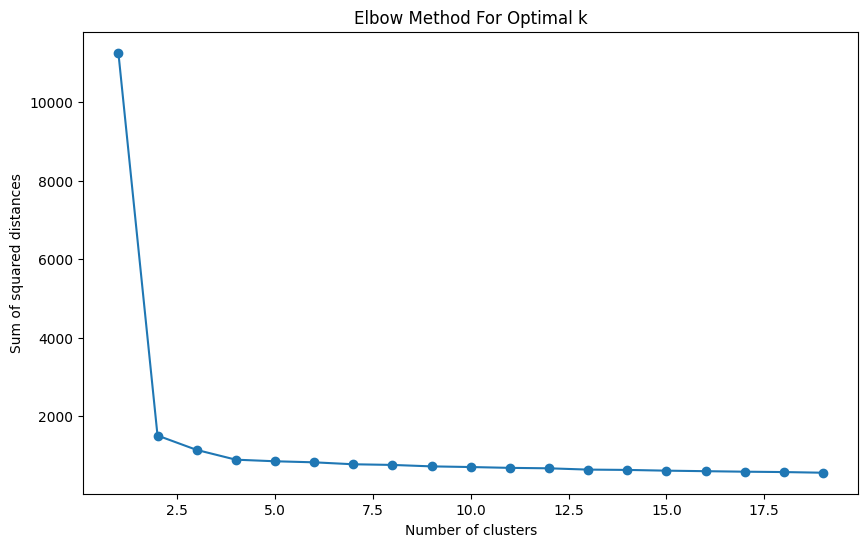

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


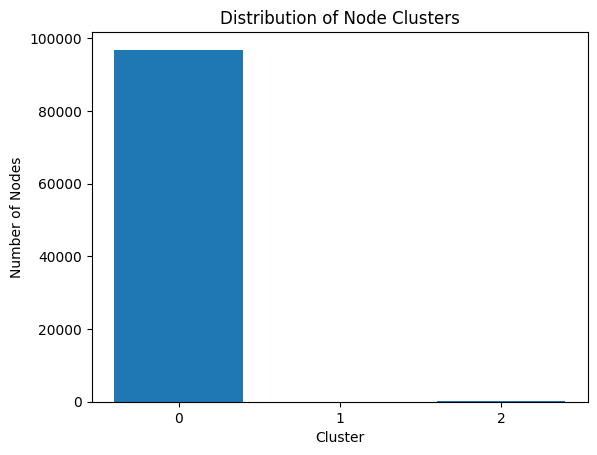

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=3, random_state=42)  #optimal cluster number
clusters = kmeans.fit_predict(node_embeddings)

import matplotlib.pyplot as plt
plt.hist(clusters, bins=np.arange(kmeans.n_clusters + 1) - 0.5, rwidth=0.8)
plt.title('Distribution of Node Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Nodes')
plt.xticks(range(kmeans.n_clusters))
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


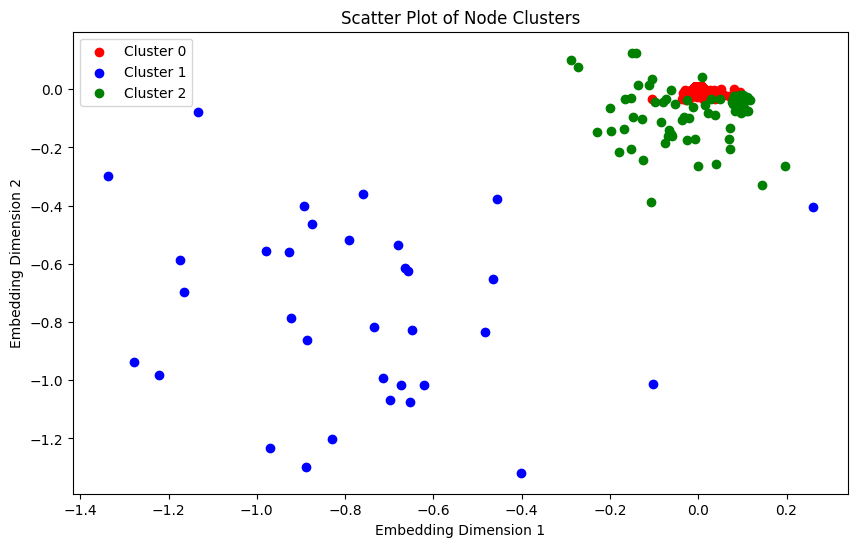

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=42)  #optimal number of clusters
clusters = kmeans.fit_predict(node_embeddings)

plt.figure(figsize=(10, 6))
colors = ['red', 'blue','green']
for i in range(kmeans.n_clusters):
    plt.scatter(node_embeddings[clusters == i, 0], node_embeddings[clusters == i, 1], color=colors[i], label=f'Cluster {i}')

plt.title('Scatter Plot of Node Clusters')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.show()


In [24]:
cluster_nodes = [[] for _ in range(kmeans.n_clusters)]

for i, node_id in enumerate(node_ids):
    cluster_label = clusters[i]
    cluster_nodes[cluster_label].append(node_id)

#for cluster_id, node_list in enumerate(cluster_nodes):
#    print(f"Nodes in Cluster {cluster_id}: {node_list}")


In [25]:
import pandas as pd

df = pd.DataFrame({'Cluster ID': range(len(cluster_nodes)), 'Node List': [','.join(map(str, lst)) for lst in cluster_nodes]})
df.to_csv(dataset+'cluster_nodes.csv', index=False)


#### Predictive Model

In [26]:
import networkx as nx

degree_dict = dict(G.degree())

df_Users['engagement_degree'] = df_Users['AccountId'].map(degree_dict)
df_Users['engagement_degree'].fillna(0, inplace=True)
max_degree = max(degree_dict.values(), default=1)  #avoid division by zero
df_Users['normalized_engagement'] = df_Users['engagement_degree'] / max_degree
threshold = df_Users['normalized_engagement'].quantile(0.75)
df_Users['is_highly_engaged'] = (df_Users['normalized_engagement'] > threshold).astype(int)


In [ ]:
df_Users = df_Users.drop(['normalized_engagement','engagement_degree'], axis=1)


In [28]:
df_Users[df_Users['is_highly_engaged']==0]

,Unnamed: 0,Reputation,AccountId,has_website,account_age_days,AboutMe_Word_Count,AboutMe_Sentiment,is_highly_engaged
0,0,1,-1,True,0,62,0.139815,0
1,1,31681,30864,True,5296,66,0.000000,0
2,2,1145,519694,True,729,0,0.000000,0
3,3,141,519695,True,127,15,0.285714,0
4,4,379,519696,True,184,0,0.000000,0
...,...,...,...,...,...,...,...,...
96885,96895,1,31113018,False,4,0,0.000000,0
96886,96896,101,1090672,True,0,0,0.000000,0
96887,96897,1,31113906,False,0,0,0.000000,0
96888,96898,1,31114054,False,0,0,0.000000,0


In [29]:
df_Users[df_Users['is_highly_engaged']>0]

,Unnamed: 0,Reputation,AccountId,has_website,account_age_days,AboutMe_Word_Count,AboutMe_Sentiment,is_highly_engaged
14,14,3768,9520,True,4301,0,0.000,1
32,32,1110,9754,True,4905,38,0.125,1
58,58,2448,207,True,5148,22,0.400,1
130,130,191,2031,True,3776,0,0.000,1
143,143,175,25224,False,1654,0,0.000,1
...,...,...,...,...,...,...,...,...
74983,74989,101,42223,True,0,5,0.000,1
78608,78614,101,67282,False,0,0,0.000,1
80244,80252,101,276,True,790,3,0.000,1
80754,80762,1,111879,True,0,0,0.000,1


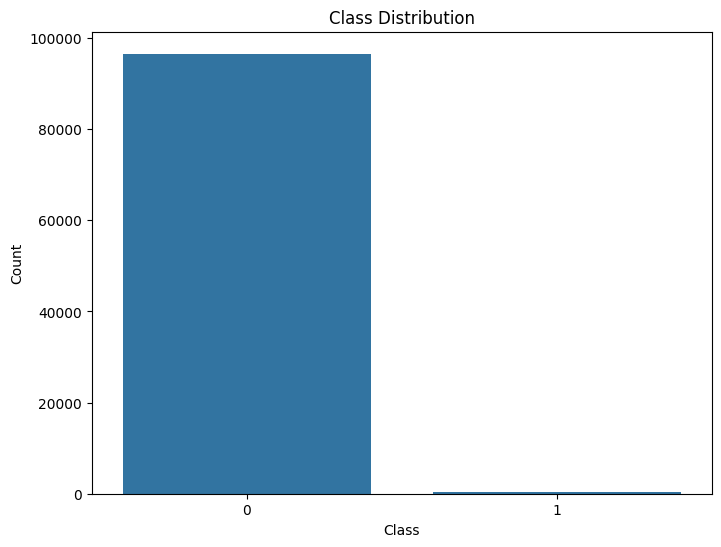

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def check_balance(df):
    counts = df['is_highly_engaged'].value_counts()
    if len(counts) != 2:
        return False
    else:
        min_count = min(counts)
        max_count = max(counts)
        balance_ratio = min_count / max_count
        if balance_ratio >= 0.8:  # Set your threshold for balance here
            return True
        else:
            return False

balanced = check_balance(df_Users)

plt.figure(figsize=(8, 6))
sns.countplot(x='is_highly_engaged', data=df_Users)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


#### Oversampling

In [64]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd


X = df_Users[['Reputation', 'account_age_days', 'has_website', 'AboutMe_Word_Count']]
y = df_Users['is_highly_engaged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)





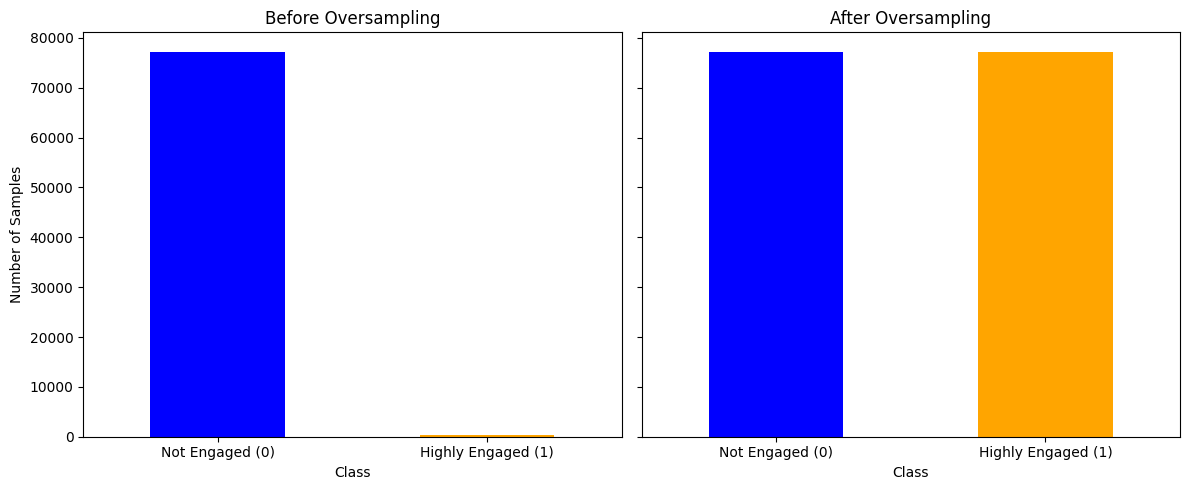

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

y_train.value_counts().plot(kind='bar', ax=ax[0], color=['blue', 'orange'])
ax[0].set_title('Before Oversampling')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Samples')
ax[0].set_xticklabels(['Not Engaged (0)', 'Highly Engaged (1)'], rotation=0)

y_train_over.value_counts().plot(kind='bar', ax=ax[1], color=['blue', 'orange'])
ax[1].set_title('After Oversampling')
ax[1].set_xlabel('Class')
ax[1].set_xticklabels(['Not Engaged (0)', 'Highly Engaged (1)'], rotation=0)

plt.tight_layout()
plt.show()

Accuracy: 0.7386727216431004

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85     19318
           1       0.01      0.75      0.02        60

    accuracy                           0.74     19378
   macro avg       0.50      0.74      0.43     19378
weighted avg       1.00      0.74      0.85     19378



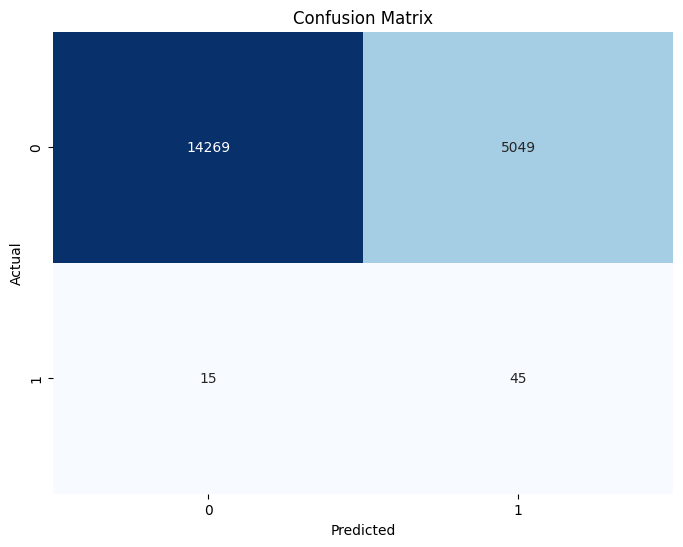

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(random_state=42)
model.fit(X_train_over, y_train_over)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

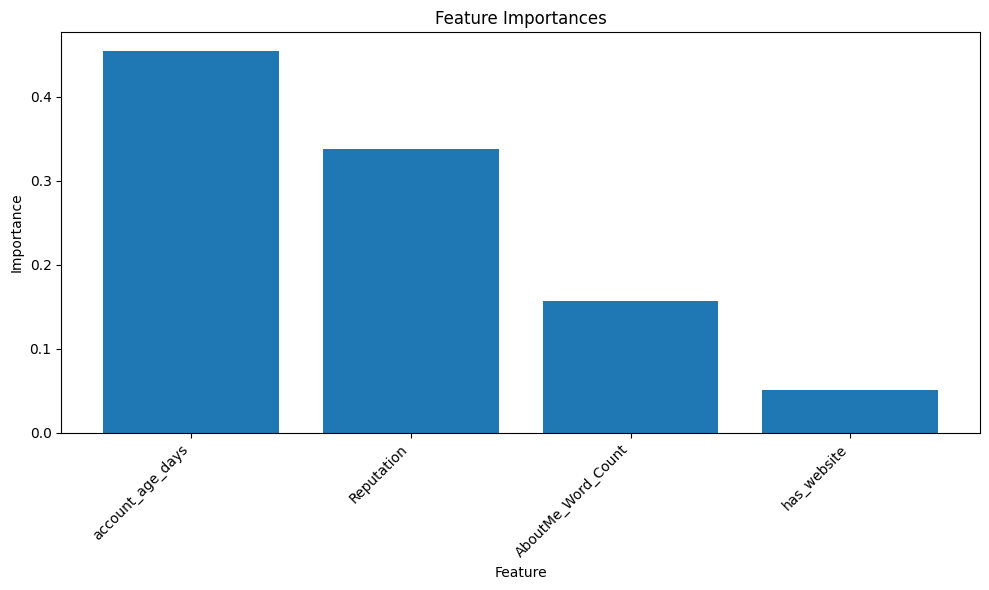

In [67]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


model = RandomForestClassifier(random_state=42)
model.fit(X_train_over, y_train_over)

#feature importances
importances = model.feature_importances_
feature_names = X_train_over.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [68]:
important_features = [feature for feature, importance in zip(feature_names, importances) if importance > 0.1]

X_train_important = X_train_over[important_features]
X_test_important = X_test[important_features]

Accuracy: 0.7851171431520281

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88     19318
           1       0.01      0.62      0.02        60

    accuracy                           0.79     19378
   macro avg       0.50      0.70      0.45     19378
weighted avg       1.00      0.79      0.88     19378



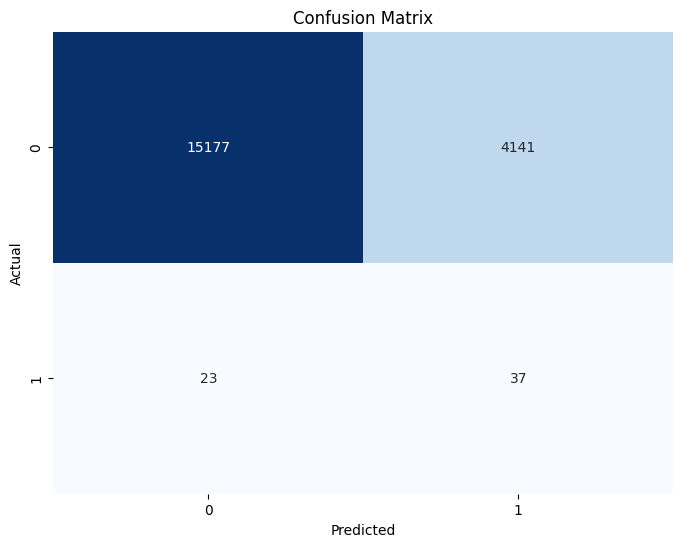

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(random_state=42)
model.fit(X_train_important, y_train_over)

y_pred = model.predict(X_test_important)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Undersampling

In [75]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


X = df_Users[['Reputation', 'account_age_days', 'has_website', 'AboutMe_Word_Count']]
y = df_Users['is_highly_engaged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

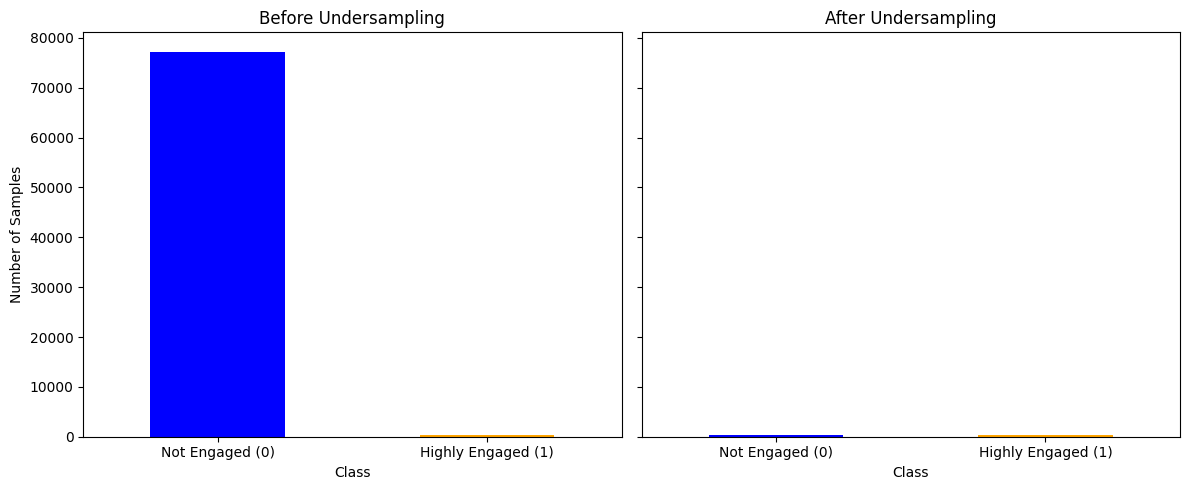

In [76]:


fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

y_train.value_counts().plot(kind='bar', ax=ax[0], color=['blue', 'orange'])
ax[0].set_title('Before Undersampling')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Samples')
ax[0].set_xticklabels(['Not Engaged (0)', 'Highly Engaged (1)'], rotation=0)

y_train_under.value_counts().plot(kind='bar', ax=ax[1], color=['blue', 'orange'])
ax[1].set_title('After Undersampling')
ax[1].set_xlabel('Class')
ax[1].set_xticklabels(['Not Engaged (0)', 'Highly Engaged (1)'], rotation=0)

plt.tight_layout()
plt.show()


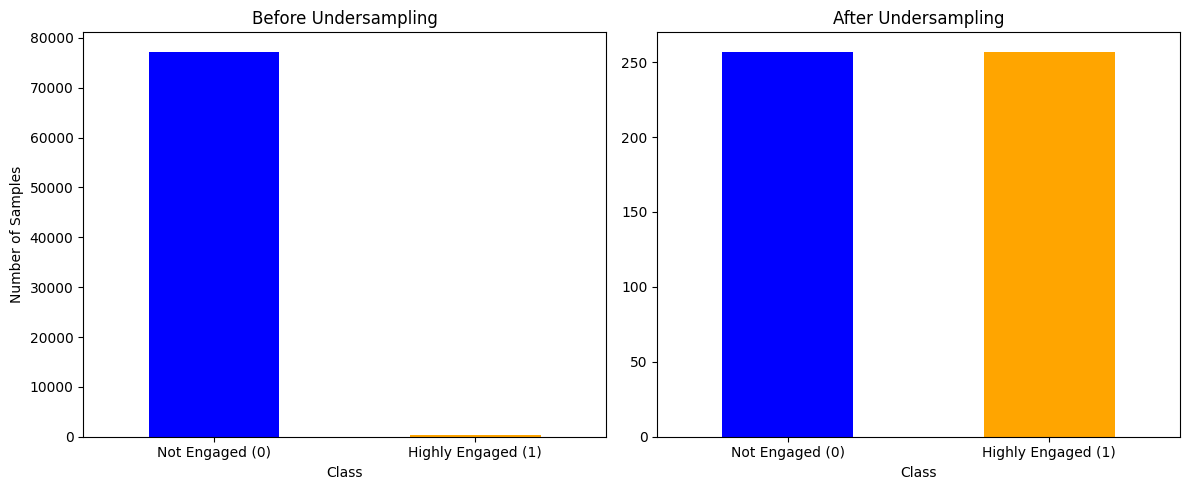

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

y_train.value_counts().plot(kind='bar', ax=ax[0], color=['blue', 'orange'])
ax[0].set_title('Before Undersampling')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Samples')
ax[0].set_xticklabels(['Not Engaged (0)', 'Highly Engaged (1)'], rotation=0)

y_train_under.value_counts().plot(kind='bar', ax=ax[1], color=['blue', 'orange'])
ax[1].set_title('After Undersampling')
ax[1].set_xlabel('Class')
ax[1].set_xticklabels(['Not Engaged (0)', 'Highly Engaged (1)'], rotation=0)

plt.tight_layout()
plt.show()

Accuracy: 0.7017236040871091

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82     19318
           1       0.01      0.78      0.02        60

    accuracy                           0.70     19378
   macro avg       0.50      0.74      0.42     19378
weighted avg       1.00      0.70      0.82     19378



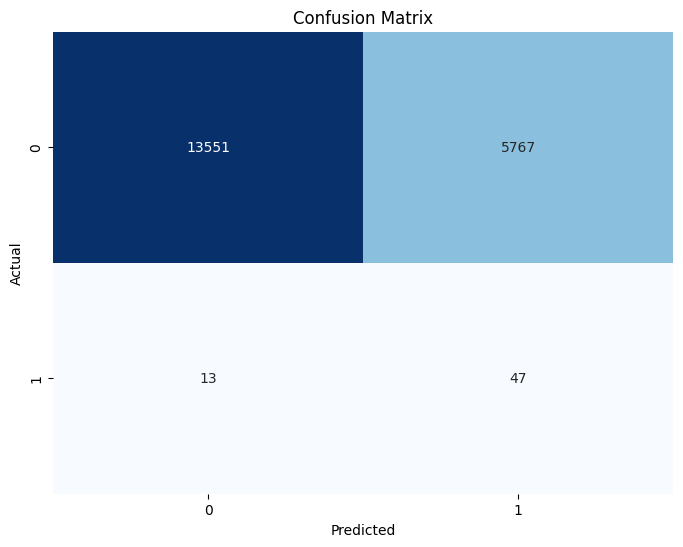

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(random_state=42)
model.fit(X_train_under, y_train_under)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

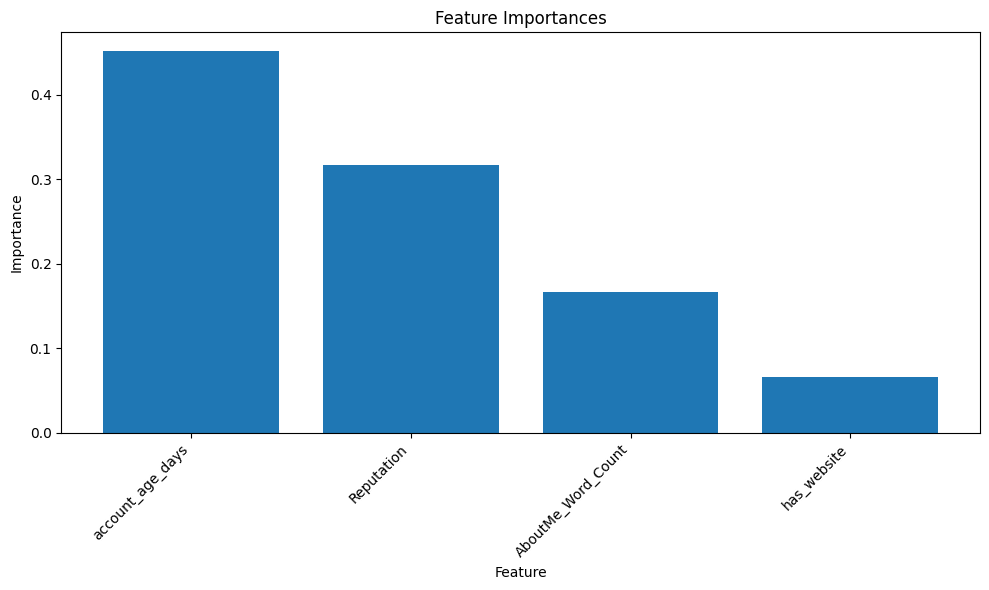

In [79]:

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


model = RandomForestClassifier(random_state=42)
model.fit(X_train_under, y_train_under)

#feature importances
importances = model.feature_importances_
feature_names = X_train_under.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [80]:
important_features = [feature for feature, importance in zip(feature_names, importances) if importance > 0.1]


X_train_important = X_train_under[important_features]
X_test_important = X_test[important_features]

Accuracy: 0.7803694911755599

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88     19318
           1       0.01      0.63      0.02        60

    accuracy                           0.78     19378
   macro avg       0.50      0.71      0.45     19378
weighted avg       1.00      0.78      0.87     19378



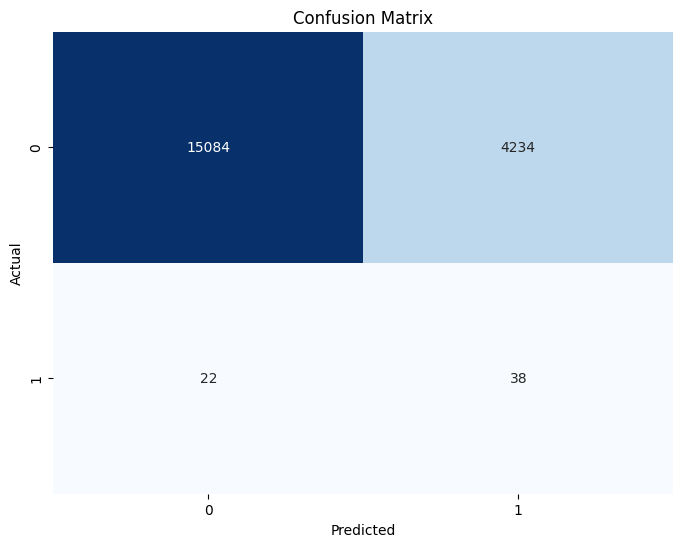

In [82]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(random_state=42)
model.fit(X_train_important, y_train_under)

y_pred = model.predict(X_test_important)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()